In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.base
import taichi as ti
import klib as kl
import warnings
import os

os.environ['KERAS_BACKEND']='tensorflow'
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = 'Kaiti'
plt.rcParams['axes.unicode_minus'] = False
PIC_PATH = "../models/solve1/"
ti.init(arch=ti.gpu)

[Taichi] version 1.1.2, llvm 10.0.0, commit f25cf4a2, win, python 3.9.7
[Taichi] Starting on arch=cuda


In [3]:
data = pd.read_excel('../data/train data.xlsx')
columns = data.columns.tolist()
columns[4] = '机械工作温度'
data.columns = columns
data

机器编号  统一规范代码 机器质量等级  室温（K）  机械工作温度  转速（rpm）  扭矩（Nm）  使用时长（min）  是否发生故障  \
0       84  L48027      L  296.4   307.4     2833     5.6        213       1   
1     6986  M15740      M  295.8   306.3     1235    76.2         89       1   
2     8047  L48083      L  295.7   306.2     2270    14.6        149       1   
3     4425  M15847      M  296.3   307.1     1534    33.8        151       0   
4     4519  H30402      H  296.3   307.1     1774    25.9        154       0   
...    ...     ...    ...    ...     ...      ...     ...        ...     ...   
8995  8680  M24855      M  298.8   308.4     1604    29.5         14       0   
8996   194  H39410      H  298.9   308.4     1632    31.8         17       0   
8997  7860  M24857      M  299.0   308.6     1645    33.4         22       0   
8998   138  H39412      H  299.0   308.7     1408    48.5         25       0   
8999   936  M24859      M  299.0   308.7     1500    40.2         30       0   

      具体故障类别  
0        PWF  
1        PWF  
2        PWF  
3     Normal  
4     Normal  
...      ...  
8995  Normal  
8996  Normal  
8997  Normal  
8998  Normal  
8999  Normal  

[9000 rows x 10 columns]

In [4]:
data.iloc[:, 1].nunique()

9000

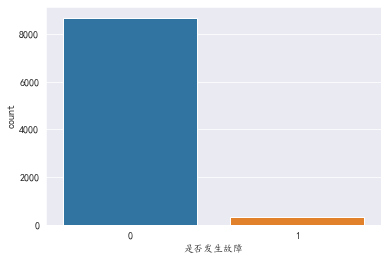

In [5]:
sns.countplot(data.iloc[:, -2])
plt.savefig(PIC_PATH + '是否发生故障.png', dpi=800)

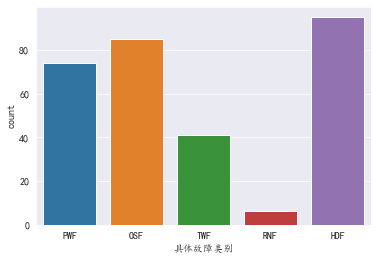

In [6]:
sns.countplot(data.iloc[:, -1][data.iloc[:, -1]!='Normal'])
plt.savefig(PIC_PATH + '具体故障类别.png', dpi=800)

array([[<AxesSubplot:title={'center':'室温（K）'}>,
        <AxesSubplot:title={'center':'机械工作温度'}>],
       [<AxesSubplot:title={'center':'转速（rpm）'}>,
        <AxesSubplot:title={'center':'扭矩（Nm）'}>],
       [<AxesSubplot:title={'center':'使用时长（min）'}>, <AxesSubplot:>]],
      dtype=object)

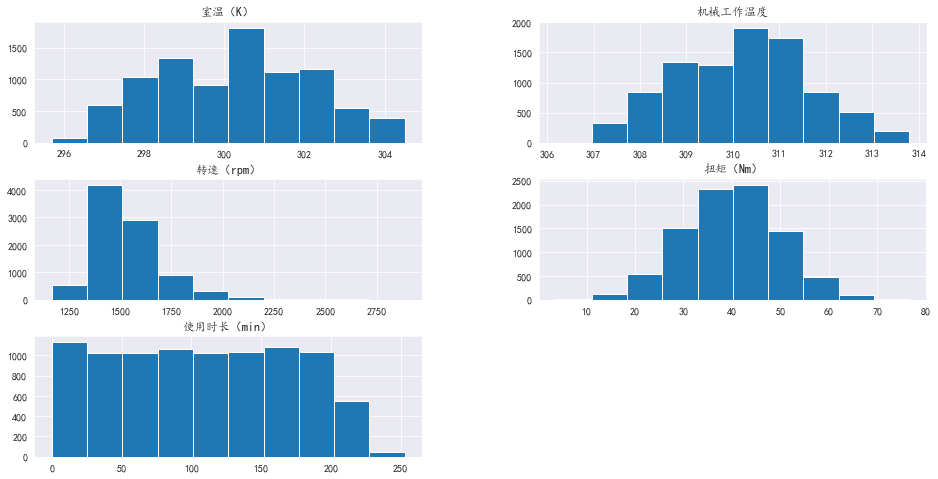

In [7]:
columns = data.columns

data.iloc[:, 2: -2].hist(figsize=(16, 8))

In [8]:
kl.missingval_plot(data)

No missing values found in the dataset.


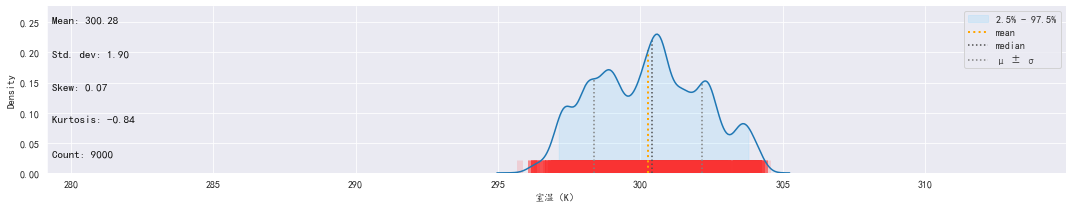

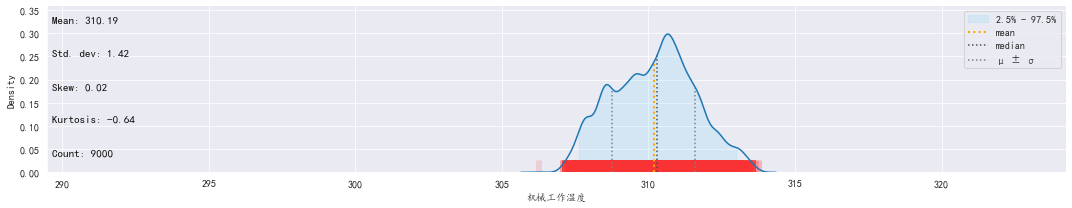

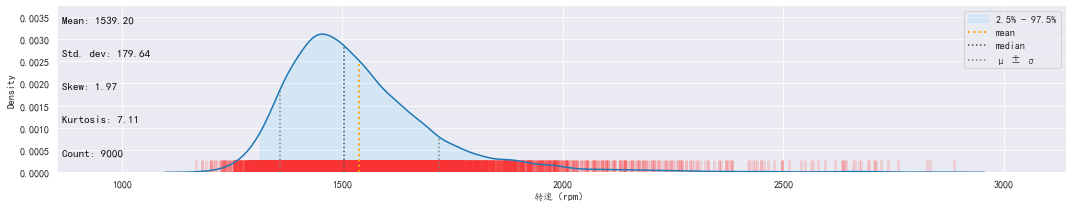

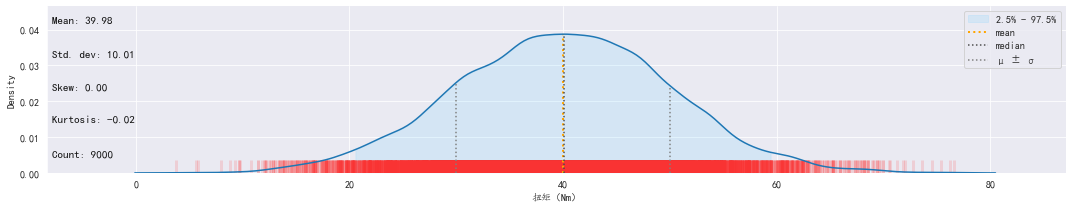

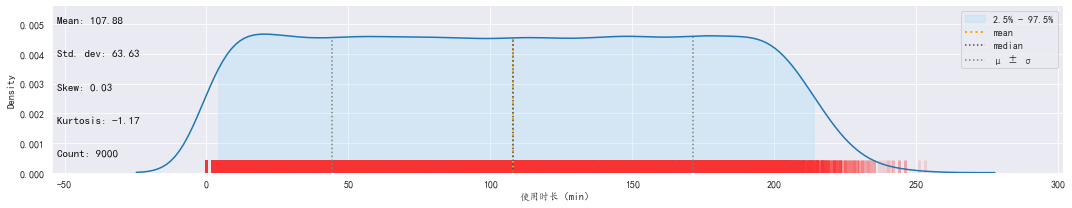

In [9]:
for column in columns[3: -2]:
    kl.dist_plot(data[column])
    plt.tight_layout()
    plt.savefig(PIC_PATH + column + ' density.png', dpi=800)

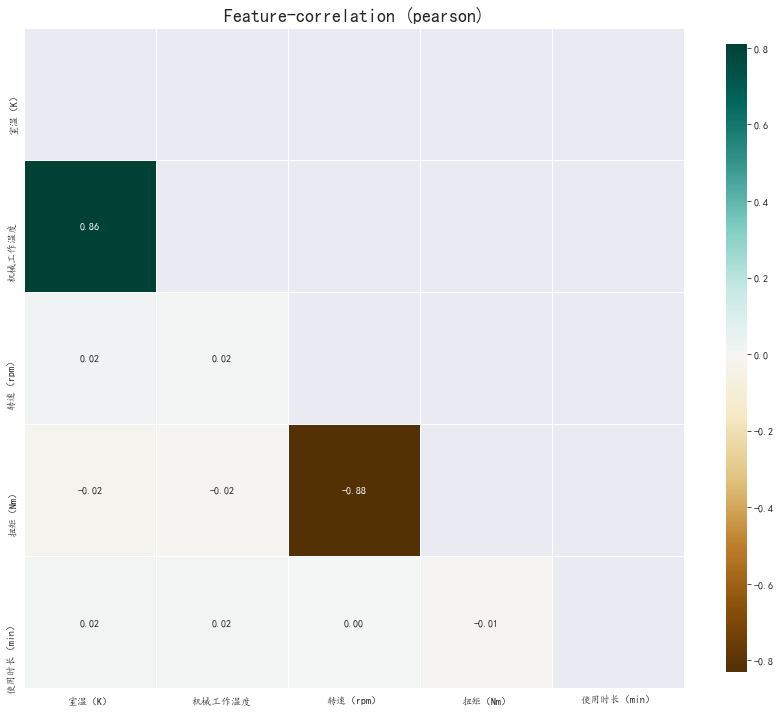

In [10]:
kl.corr_plot(data[columns[3: -2]])
plt.tight_layout()
plt.savefig(PIC_PATH + 'pearsonr.png', dpi=800)

In [11]:
def cov(df: pd.DataFrame):
    return df.std() / df.mean()

In [12]:
cov(data)

机器编号         0.582294
室温（K）        0.006316
机械工作温度       0.004573
转速（rpm）      0.116710
扭矩（Nm）       0.250394
使用时长（min）    0.589813
是否发生故障       5.357813
dtype: float64

In [13]:
class_group = data.groupby('是否发生故障')

In [14]:
data[columns[-2:]].value_counts()

是否发生故障  具体故障类别
0       Normal    8697
1       HDF         95
        OSF         85
        PWF         74
        TWF         41
        RNF          6
        Normal       2
dtype: int64

In [15]:
outlier = class_group.get_group(1)
normal = class_group.get_group(0)

In [16]:
ques = outlier[outlier['具体故障类别'] == 'Normal']
ques

机器编号  统一规范代码 机器质量等级  室温（K）  机械工作温度  转速（rpm）  扭矩（Nm）  使用时长（min）  是否发生故障  \
7506  7729  L55686      L  298.4   309.6     1710    27.3        163       1   
8015  3433  L56195      L  297.2   308.1     1431    49.7        210       1   

      具体故障类别  
7506  Normal  
8015  Normal

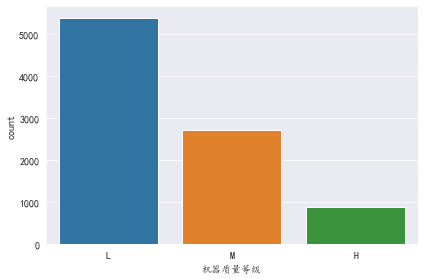

In [17]:
sns.countplot(data.iloc[:, 2])
plt.tight_layout()
plt.savefig(PIC_PATH + '机器质量等级', dpi=800)

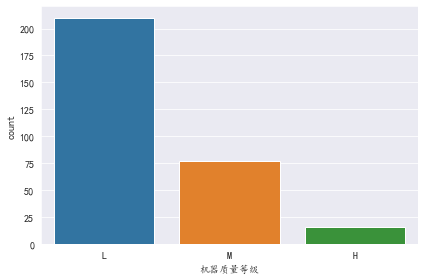

In [18]:
sns.countplot(outlier.iloc[:, 2])
plt.tight_layout()
plt.savefig(PIC_PATH + '故障机器质量等级', dpi=800)

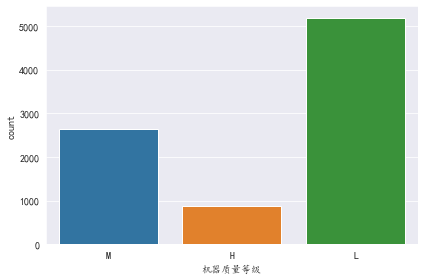

In [19]:
sns.countplot(normal.iloc[:, 2])
plt.tight_layout()
plt.savefig(PIC_PATH + '正常机器质量等级', dpi=800)

In [20]:
normal.describe()

机器编号        室温（K）       机械工作温度      转速（rpm）       扭矩（Nm）  \
count  8697.000000  8697.000000  8697.000000  8697.000000  8697.000000   
mean   4468.179257   300.246717   310.176406  1540.884328    39.622812   
std    2594.771103     1.887138     1.421293   168.321249     9.520060   
min       1.000000   296.100000   307.000000  1168.000000    12.600000   
25%    2202.000000   298.700000   309.100000  1429.000000    33.000000   
50%    4455.000000   300.300000   310.300000  1507.000000    39.800000   
75%    6720.000000   301.700000   311.200000  1615.000000    46.300000   
max    9000.000000   304.500000   313.800000  2695.000000    70.000000   

         使用时长（min）  是否发生故障  
count  8697.000000  8697.0  
mean    106.610095     0.0  
std      62.900694     0.0  
min       0.000000     0.0  
25%      52.000000     0.0  
50%     106.000000     0.0  
75%     160.000000     0.0  
max     246.000000     0.0

In [21]:
normal.skew(), normal.kurtosis()

(机器编号         0.009757
 室温（K）        0.096779
 机械工作温度       0.038803
 转速（rpm）      1.602033
 扭矩（Nm）      -0.058055
 使用时长（min）    0.028288
 是否发生故障       0.000000
 dtype: float64,
 机器编号        -1.196248
 室温（K）       -0.815458
 机械工作温度      -0.647942
 转速（rpm）      4.414997
 扭矩（Nm）      -0.272326
 使用时长（min）   -1.168414
 是否发生故障       0.000000
 dtype: float64)

In [22]:
outlier.describe()

机器编号       室温（K）      机械工作温度      转速（rpm）      扭矩（Nm）  \
count   303.000000  303.000000  303.000000   303.000000  303.000000   
mean   4310.653465  301.089109  310.433993  1490.732673   50.370297   
std    2709.287534    1.984204    1.309416   378.611804   16.285163   
min      48.000000  295.700000  306.200000  1181.000000    3.800000   
25%    1820.500000  299.550000  309.800000  1325.000000   46.200000   
50%    4187.000000  301.700000  310.500000  1363.000000   53.600000   
75%    6632.500000  302.600000  311.300000  1416.500000   61.200000   
max    9000.000000  304.400000  313.700000  2886.000000   76.600000   

        使用时长（min）  是否发生故障  
count  303.000000   303.0  
mean   144.372937     1.0  
std     73.050261     0.0  
min      0.000000     1.0  
25%     82.500000     1.0  
50%    168.000000     1.0  
75%    207.000000     1.0  
max    253.000000     1.0

In [23]:
outlier.skew(), outlier.kurtosis()

(机器编号         0.115390
 室温（K）       -0.673100
 机械工作温度      -0.494382
 转速（rpm）      2.539904
 扭矩（Nm）      -1.180303
 使用时长（min）   -0.529725
 是否发生故障       0.000000
 dtype: float64,
 机器编号        -1.242491
 室温（K）       -0.512878
 机械工作温度       0.211637
 转速（rpm）      5.179918
 扭矩（Nm）       0.874419
 使用时长（min）   -1.109914
 是否发生故障       0.000000
 dtype: float64)

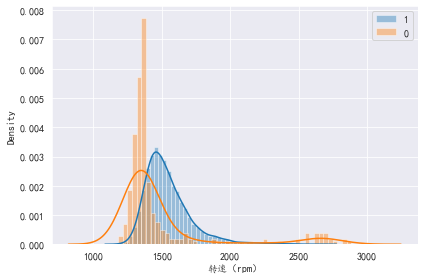

In [24]:
sns.distplot(normal['转速（rpm）'], label='1')
sns.distplot(outlier['转速（rpm）'], label='0')
plt.legend()
plt.tight_layout()
plt.savefig(PIC_PATH + 'rpm对比.png', dpi=800)

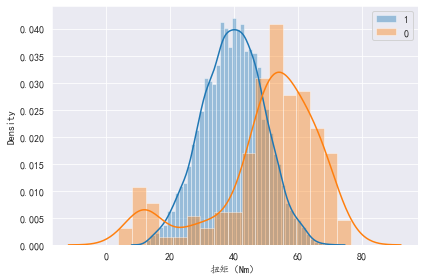

In [25]:
sns.distplot(normal['扭矩（Nm）'], label='1')
sns.distplot(outlier['扭矩（Nm）'], label='0')
plt.legend()
plt.tight_layout()
plt.savefig(PIC_PATH + 'Nm对比.png', dpi=800)

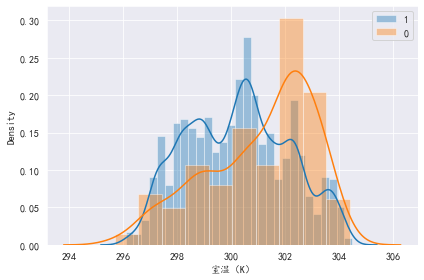

In [26]:
sns.distplot(normal['室温（K）'], label='1')
sns.distplot(outlier['室温（K）'], label='0')
plt.legend()
plt.tight_layout()
plt.savefig(PIC_PATH + 'K对比.png', dpi=800)

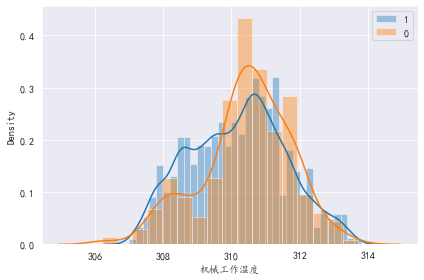

In [27]:
sns.distplot(normal['机械工作温度'], label='1')
sns.distplot(outlier['机械工作温度'], label='0')
plt.legend()
plt.tight_layout()
plt.savefig(PIC_PATH + 'K.1对比.png', dpi=800)

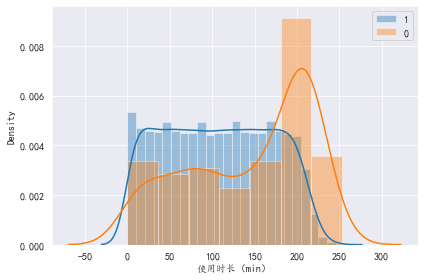

In [28]:
sns.distplot(normal['使用时长（min）'], label='1')
sns.distplot(outlier['使用时长（min）'], label='0')
plt.legend()
plt.tight_layout()
plt.savefig(PIC_PATH + 'time对比.png', dpi=800)

In [29]:
ques

机器编号  统一规范代码 机器质量等级  室温（K）  机械工作温度  转速（rpm）  扭矩（Nm）  使用时长（min）  是否发生故障  \
7506  7729  L55686      L  298.4   309.6     1710    27.3        163       1   
8015  3433  L56195      L  297.2   308.1     1431    49.7        210       1   

      具体故障类别  
7506  Normal  
8015  Normal

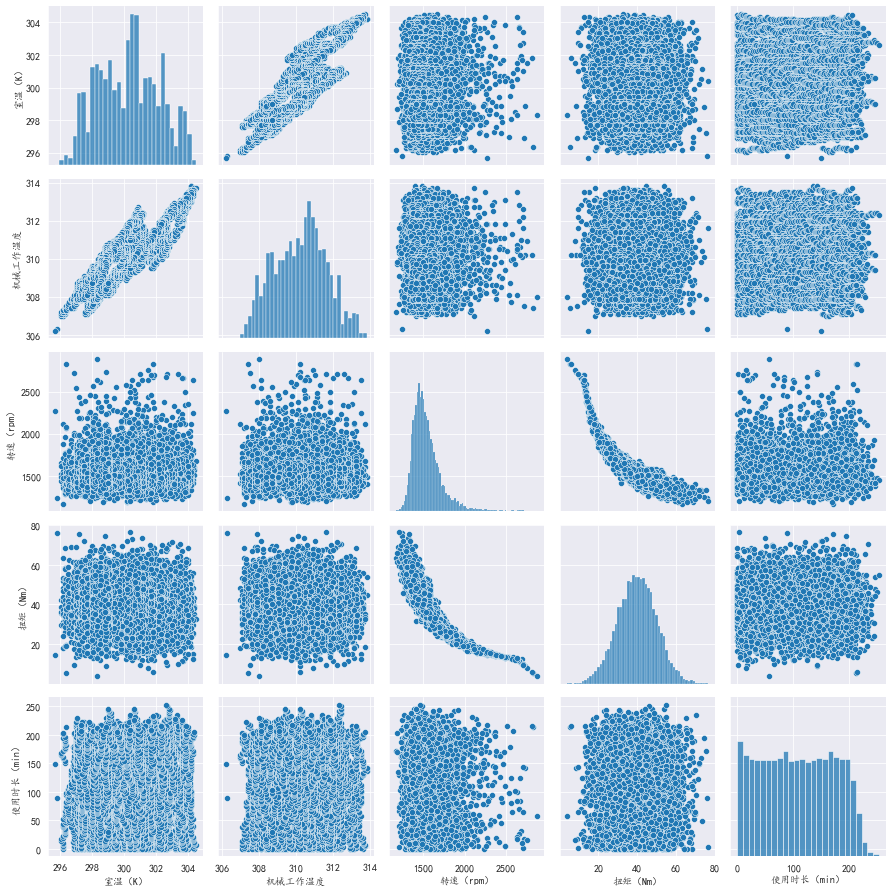

In [30]:
sns.pairplot(data[columns[3: -2]])
plt.tight_layout()
plt.savefig(PIC_PATH + '联合分布.png', dpi=800)

In [31]:
def compute(df):
    record = pd.DataFrame(columns=columns[3:-2])
    record.iloc[:, 0] = (ques['室温（K）'] - df['室温（K）'].mean()) / df['室温（K）'].std()
    # record.iloc[:, 1] = (ques['室温（K）'] - outlier['室温（K）'].mean()) / outlier['室温（K）'].std()
    record.iloc[:, 1] = (ques['机械工作温度'] - df['机械工作温度'].mean()) / df['机械工作温度'].std()
    record.iloc[:, 2] = (ques['转速（rpm）'] - df['转速（rpm）'].mean()) / df['转速（rpm）'].std()
    record.iloc[:, 3] = (ques['扭矩（Nm）'] - df['扭矩（Nm）'].mean()) / df['扭矩（Nm）'].std()
    record.iloc[:, 2] = (ques['使用时长（min）'] - df['使用时长（min）'].mean()) / df['使用时长（min）'].std()
    return record

In [32]:
normal_record = compute(normal)
outlier_record = compute(outlier)

In [33]:
normal_record

室温（K）    机械工作温度   转速（rpm）    扭矩（Nm） 使用时长（min）
7506 -0.978581 -0.405550  0.896491 -1.294405       NaN
8015 -1.614465 -1.460927  1.643701  1.058521       NaN

In [34]:
outlier_record

室温（K）   机械工作温度   转速（rpm）    扭矩（Nm） 使用时长（min）
7506 -1.355258 -0.63692  0.254990 -1.416645       NaN
8015 -1.960035 -1.78247  0.898382 -0.041160       NaN

In [35]:
data.drop(ques.index, inplace=True)
data

机器编号  统一规范代码 机器质量等级  室温（K）  机械工作温度  转速（rpm）  扭矩（Nm）  使用时长（min）  是否发生故障  \
0       84  L48027      L  296.4   307.4     2833     5.6        213       1   
1     6986  M15740      M  295.8   306.3     1235    76.2         89       1   
2     8047  L48083      L  295.7   306.2     2270    14.6        149       1   
3     4425  M15847      M  296.3   307.1     1534    33.8        151       0   
4     4519  H30402      H  296.3   307.1     1774    25.9        154       0   
...    ...     ...    ...    ...     ...      ...     ...        ...     ...   
8995  8680  M24855      M  298.8   308.4     1604    29.5         14       0   
8996   194  H39410      H  298.9   308.4     1632    31.8         17       0   
8997  7860  M24857      M  299.0   308.6     1645    33.4         22       0   
8998   138  H39412      H  299.0   308.7     1408    48.5         25       0   
8999   936  M24859      M  299.0   308.7     1500    40.2         30       0   

      具体故障类别  
0        PWF  
1        PWF  
2        PWF  
3     Normal  
4     Normal  
...      ...  
8995  Normal  
8996  Normal  
8997  Normal  
8998  Normal  
8999  Normal  

[8998 rows x 10 columns]

In [36]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
target = data.iloc[:, -2]
train = data.iloc[:, 2: -2]
train

机器质量等级  室温（K）  机械工作温度  转速（rpm）  扭矩（Nm）  使用时长（min）
0         L  296.4   307.4     2833     5.6        213
1         M  295.8   306.3     1235    76.2         89
2         L  295.7   306.2     2270    14.6        149
3         M  296.3   307.1     1534    33.8        151
4         H  296.3   307.1     1774    25.9        154
...     ...    ...     ...      ...     ...        ...
8995      M  298.8   308.4     1604    29.5         14
8996      H  298.9   308.4     1632    31.8         17
8997      M  299.0   308.6     1645    33.4         22
8998      H  299.0   308.7     1408    48.5         25
8999      M  299.0   308.7     1500    40.2         30

[8998 rows x 6 columns]

In [37]:
train.iloc[:, 1:] = ss.fit_transform(train.iloc[:, 1:])
train

机器质量等级     室温（K）    机械工作温度   转速（rpm）    扭矩（Nm）  使用时长（min）
0         L -2.043899 -1.963940  7.202349 -3.434702   1.652519
1         M -2.360322 -2.739539 -1.693350  3.617505  -0.296502
2         L -2.413059 -2.810048  4.068257 -2.535695   0.646573
3         M -2.096636 -2.175467 -0.028886 -0.617815   0.678009
4         H -2.096636 -2.175467  1.307139 -1.406943   0.725162
...     ...       ...       ...       ...       ...        ...
8995      M -0.778205 -1.258850  0.360788 -1.047340  -1.475346
8996      H -0.725468 -1.258850  0.516658 -0.817594  -1.428192
8997      M -0.672731 -1.117832  0.589026 -0.657771  -1.349603
8998      H -0.672731 -1.047323 -0.730299  0.850563  -1.302449
8999      M -0.672731 -1.047323 -0.218156  0.021479  -1.223859

[8998 rows x 6 columns]

In [38]:
level_map = {
    'L': 0,
    'M': 1,
    'H': 2
}

train['机器质量等级'] = train.iloc[:, 0].map(level_map)
train

机器质量等级     室温（K）    机械工作温度   转速（rpm）    扭矩（Nm）  使用时长（min）
0          0 -2.043899 -1.963940  7.202349 -3.434702   1.652519
1          1 -2.360322 -2.739539 -1.693350  3.617505  -0.296502
2          0 -2.413059 -2.810048  4.068257 -2.535695   0.646573
3          1 -2.096636 -2.175467 -0.028886 -0.617815   0.678009
4          2 -2.096636 -2.175467  1.307139 -1.406943   0.725162
...      ...       ...       ...       ...       ...        ...
8995       1 -0.778205 -1.258850  0.360788 -1.047340  -1.475346
8996       2 -0.725468 -1.258850  0.516658 -0.817594  -1.428192
8997       1 -0.672731 -1.117832  0.589026 -0.657771  -1.349603
8998       2 -0.672731 -1.047323 -0.730299  0.850563  -1.302449
8999       1 -0.672731 -1.047323 -0.218156  0.021479  -1.223859

[8998 rows x 6 columns]

In [39]:
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

model_list = [
    DBSCAN(), IsolationForest(), LocalOutlierFactor()
]
score_list = []

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=.3, random_state=42)

for model in model_list:
    y_hat = model.fit_predict(train, target)
    score_list.append(f1_score(target, y_hat, average='micro'))
score_list

[0.011891531451433651, 0.012669482107134918, 0.03245165592353856]

In [40]:
test = pd.concat([train, target], axis=1)
test

机器质量等级     室温（K）    机械工作温度   转速（rpm）    扭矩（Nm）  使用时长（min）  是否发生故障
0          0 -2.043899 -1.963940  7.202349 -3.434702   1.652519       1
1          1 -2.360322 -2.739539 -1.693350  3.617505  -0.296502       1
2          0 -2.413059 -2.810048  4.068257 -2.535695   0.646573       1
3          1 -2.096636 -2.175467 -0.028886 -0.617815   0.678009       0
4          2 -2.096636 -2.175467  1.307139 -1.406943   0.725162       0
...      ...       ...       ...       ...       ...        ...     ...
8995       1 -0.778205 -1.258850  0.360788 -1.047340  -1.475346       0
8996       2 -0.725468 -1.258850  0.516658 -0.817594  -1.428192       0
8997       1 -0.672731 -1.117832  0.589026 -0.657771  -1.349603       0
8998       2 -0.672731 -1.047323 -0.730299  0.850563  -1.302449       0
8999       1 -0.672731 -1.047323 -0.218156  0.021479  -1.223859       0

[8998 rows x 7 columns]

<AxesSubplot:xlabel='转速（rpm）', ylabel='Density'>

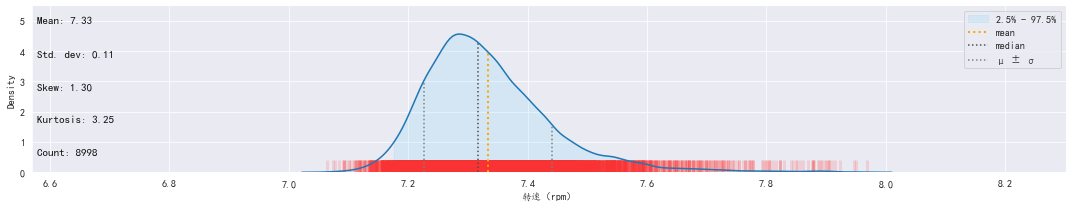

In [41]:
kl.dist_plot(np.log(1 + data['转速（rpm）']))

In [42]:
np.corrcoef(data['扭矩（Nm）'], 1 / data['转速（rpm）']), np.corrcoef(data['室温（K）'], data['机械工作温度'])

(array([[1.        , 0.91529232],
        [0.91529232, 1.        ]]),
 array([[1.        , 0.86031114],
        [0.86031114, 1.        ]]))

In [43]:
def harmonic_mean(data1):
    lst = []

    for i in data1.values:
        total = 0
        for j in i:
            total += 1/j
        lst.append(len(i)/total)

    return lst

In [44]:
new_data = pd.DataFrame()

new_data.index = data['机器编号']
new_data['temp'] = harmonic_mean(data[['室温（K）', '机械工作温度']])
new_data['npm'] = (data['扭矩（Nm）'] * data['转速（rpm）']).tolist()
new_data['level'] = (data['机器质量等级'].map(level_map)).tolist()
new_data['time'] = (data['使用时长（min）']).tolist()
new_data['target'] = (data['是否发生故障']).tolist()
new_data

temp      npm  level  time  target
机器编号                                          
84    301.799801  15864.8      0   213       1
6986  300.958445  94107.0      1    89       1
8047  300.858415  33142.0      0   149       1
4425  301.603348  51849.2      1   151       0
4519  301.603348  45946.6      2   154       0
...          ...      ...    ...   ...     ...
8680  303.524111  47318.0      1    14       0
194   303.575696  51897.6      2    17       0
7860  303.724161  54943.0      1    22       0
138   303.772585  68288.0      2    25       0
936   303.772585  60300.0      1    30       0

[8998 rows x 5 columns]

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

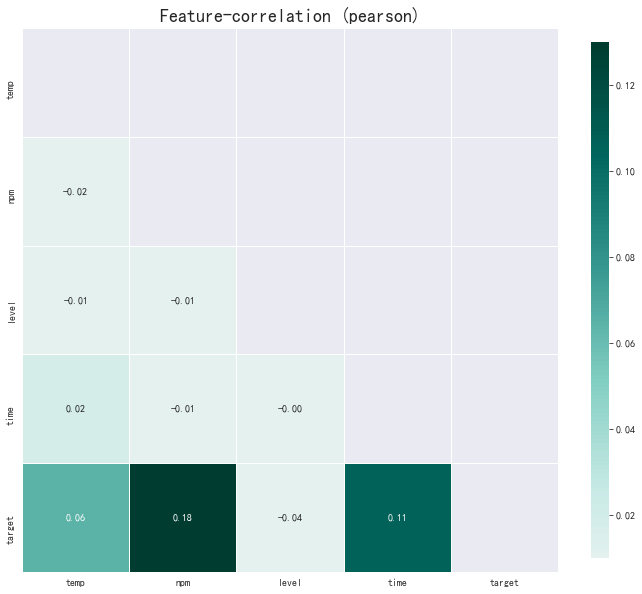

In [45]:
kl.corr_plot(new_data)

<AxesSubplot:xlabel='npm', ylabel='Density'>

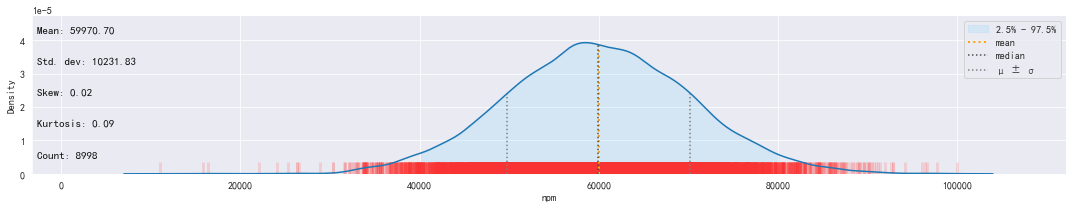

In [46]:
kl.dist_plot(new_data['npm'])

<AxesSubplot:xlabel='temp', ylabel='Density'>

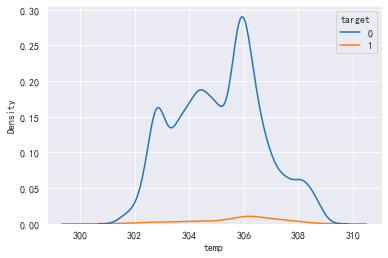

In [47]:
sns.kdeplot(data=new_data, x='temp', hue='target')

(<Figure size 432x288 with 3 Axes>,
 {('0', '1'): (0.0, 0.0, 0.5936412712175864, 0.038426129768242404),
  ('0', '0'): (0.0,
   0.04174838890445503,
   0.5936412712175864,
   0.9582516110955449),
  ('1', '1'): (0.5985917662670913,
   0.0,
   0.29907636240396657,
   0.02823553570511833),
  ('1', '0'): (0.5985917662670913,
   0.031557794841330956,
   0.29907636240396657,
   0.968442205158669),
  ('2', '1'): (0.9026186237205628,
   0.0,
   0.09738137627943722,
   0.018019032603187116),
  ('2', '0'): (0.9026186237205628,
   0.02134129173939974,
   0.09738137627943722,
   0.9786587082606002)})

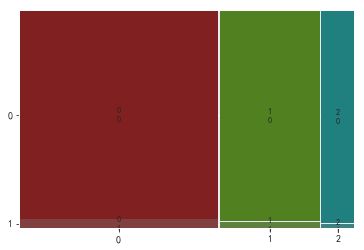

In [48]:
from statsmodels.graphics.mosaicplot import mosaic

mosaic(new_data, ['level', 'target'])

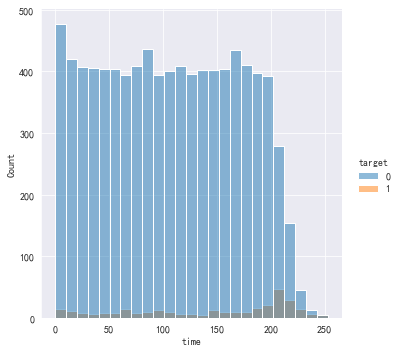

In [49]:
sns.displot(new_data, x='time', hue='target')

In [50]:
cluster = new_data.copy()
cluster[['temp', 'npm', 'time']] = ss.fit_transform(cluster[['temp', 'npm', 'time']])

In [51]:
from sklearn.cluster import KMeans


model_list = [
    KMeans(n_clusters=2), DBSCAN(1), IsolationForest(), LocalOutlierFactor()
]
score_list = []

for model in model_list:
    y_hat = model.fit_predict(cluster.drop('target', axis=1))
    np.where(y_hat<=0, 0, 1)
    score_list.append(f1_score(new_data['target'], y_hat, average='micro'))
score_list

[0.5126694821071349,
 0.2949544343187375,
 0.008224049788841965,
 0.030228939764392088]

In [52]:
import scipy.stats as stats

stats.pointbiserialr(cluster['target'], new_data['npm'])

PointbiserialrResult(correlation=0.17797198908757714, pvalue=6.282832338931709e-65)

In [53]:
stats.pointbiserialr(new_data['target'], new_data['temp'])

PointbiserialrResult(correlation=0.06434390042400524, pvalue=1.0025552594497353e-09)

In [54]:
stats.mannwhitneyu(new_data[new_data['target']==0],
                   new_data[new_data['target']==1],
                   alternative='two-sided')
# cohen's D

MannwhitneyuResult(statistic=array([ 998898.5,  658429. , 1445071.5,  880532.5,       0. ]), pvalue=array([2.62250824e-12, 8.54726173e-49, 4.08011751e-04, 4.11616518e-22,
       0.00000000e+00]))

In [55]:
new_group = new_data.groupby('target')
bad = new_group.get_group(1)
good = new_group.get_group(0)

In [56]:
bad

temp      npm  level  time  target
机器编号                                          
84    301.799801  15864.8      0   213       1
6986  300.958445  94107.0      1    89       1
8047  300.858415  33142.0      0   149       1
6852  301.651566  90087.7      1    24       1
6723  302.303571  78114.0      0   202       1
...          ...      ...    ...   ...     ...
5212  304.096910  36790.2      0   218       1
6607  303.900493  86309.8      0    12       1
2704  303.852278  82824.0      0   187       1
3919  303.700428  75005.7      0   206       1
128   303.324061  92820.2      0   172       1

[301 rows x 5 columns]

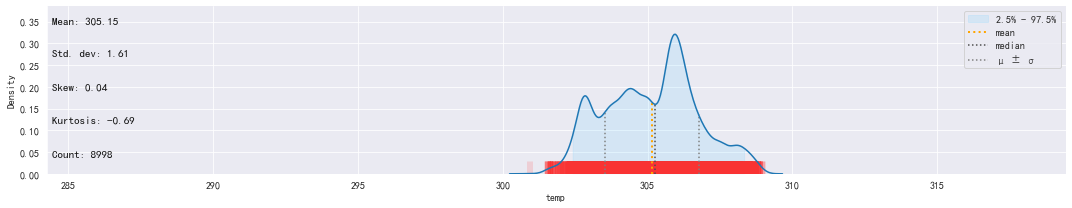

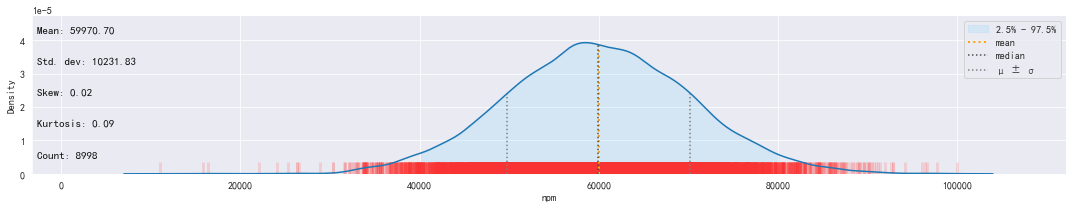

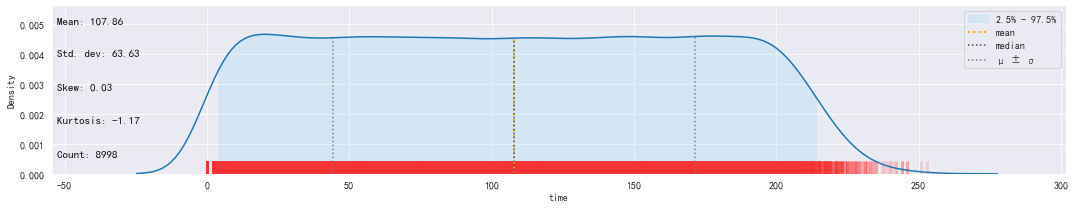

In [57]:
label = {
    'temp': '温度调和平均值',
    'npm': '转速扭矩积',
    'time': '使用时间'
}

for col in new_data.columns[:-1]:
    if col != 'level':
        kl.dist_plot(new_data[col])
        plt.savefig(PIC_PATH + col + ' all transform.png', dpi=800)

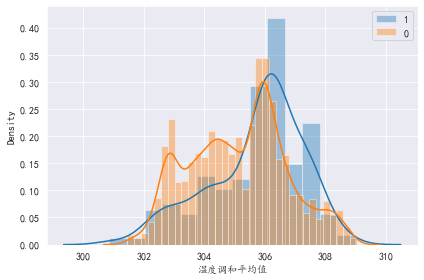

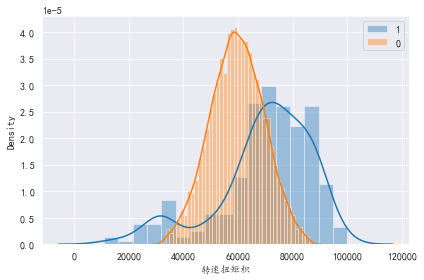

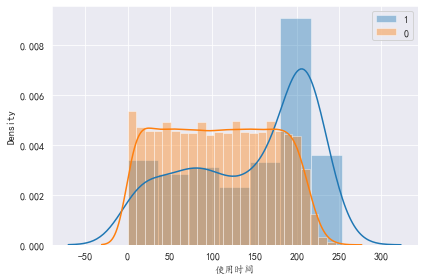

In [58]:
for col in ['temp', 'npm', 'time']:
    plt.figure()
    sns.distplot(bad[col], label='1')
    sns.distplot(good[col], label='0')
    plt.xlabel(label[col])
    plt.legend()
    plt.tight_layout()
    plt.savefig(PIC_PATH + col + ' transform.png', dpi=800)

In [59]:
bad['level'].value_counts()

0    208
1     77
2     16
Name: level, dtype: int64

In [60]:
bad['level'].value_counts() / new_data['level'].value_counts()

0    0.038554
1    0.028330
2    0.018079
Name: level, dtype: float64

In [61]:
def ana_level(df1, df2, name):
    sns.distplot(df1[name], label='0')
    sns.distplot(df2[name], label='1')
    plt.legend()
    plt.savefig(PIC_PATH + name + ' level dietubed.png', dpi=800)

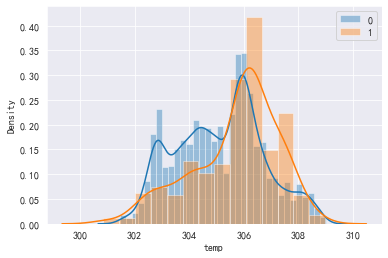

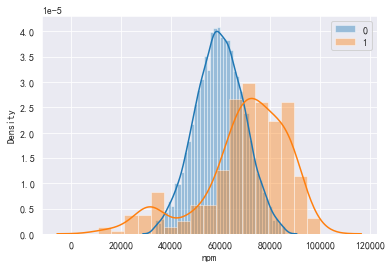

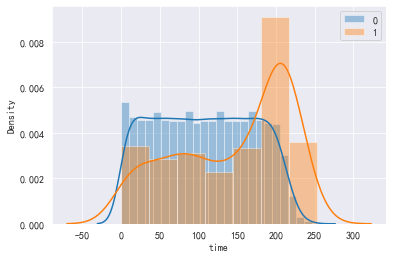

In [62]:
for col in ['temp', 'npm', 'time']:
    plt.figure()
    ana_level(good, bad, col)

In [63]:
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture

gauss = BayesianGaussianMixture(n_components=2, tol=10)
y_hat = gauss.fit_predict(new_data.drop('target', axis=1))
f1_score(new_data['target'], y_hat)

0.10362020377194885

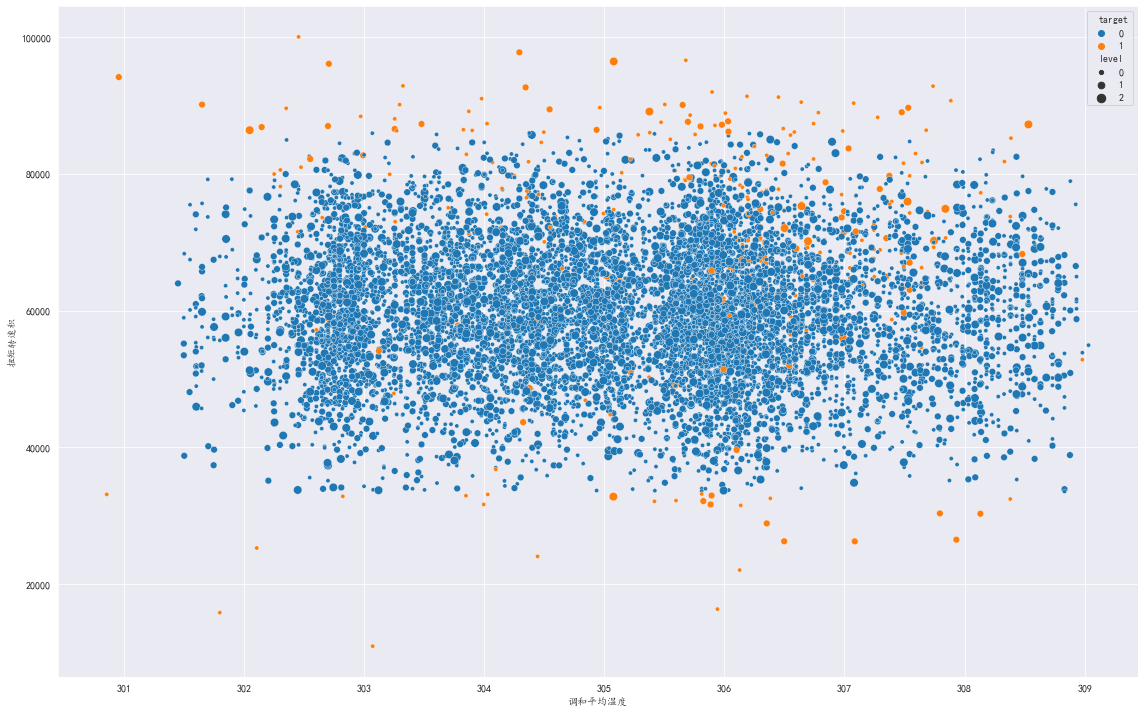

In [64]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=new_data, x='temp', y='npm', size='level', hue='target')
plt.xlabel('调和平均温度')
plt.ylabel('扭矩转速积')
plt.tight_layout()
plt.savefig(PIC_PATH + '温度-扭转速度积分布.png', dpi=800)

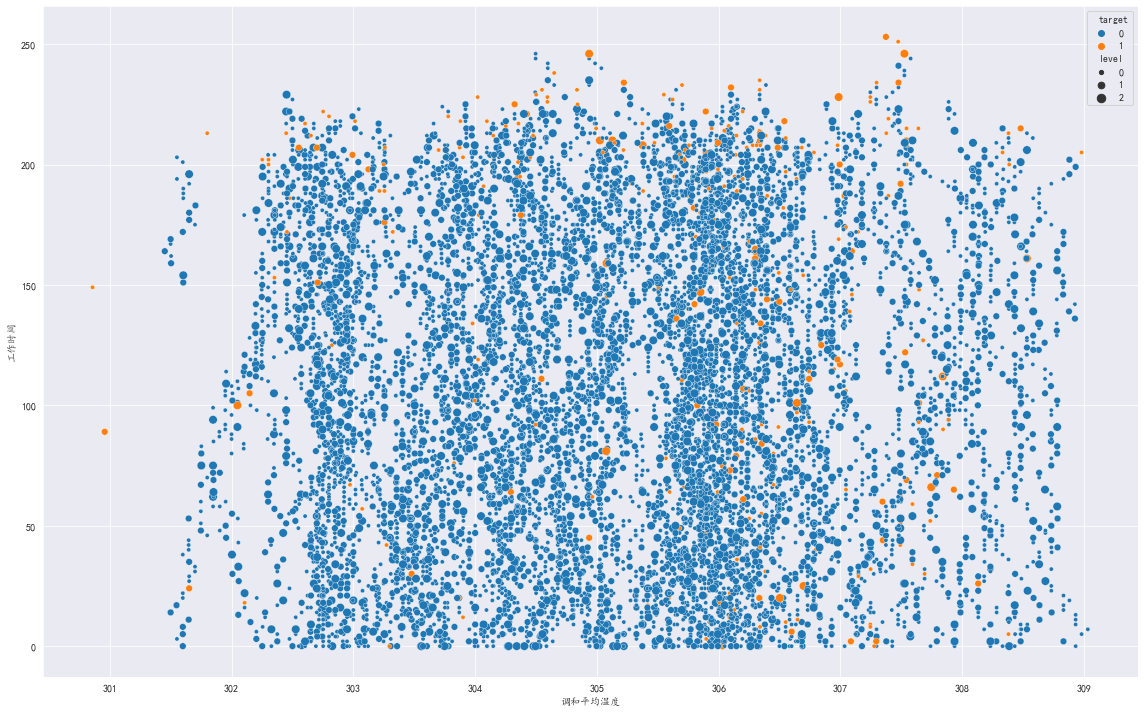

In [65]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=new_data, x='temp', y='time', size='level', hue='target')
plt.xlabel('调和平均温度')
plt.ylabel('工作时间')
plt.tight_layout()
plt.savefig(PIC_PATH + '时间-扭转速度积分布.png', dpi=800)

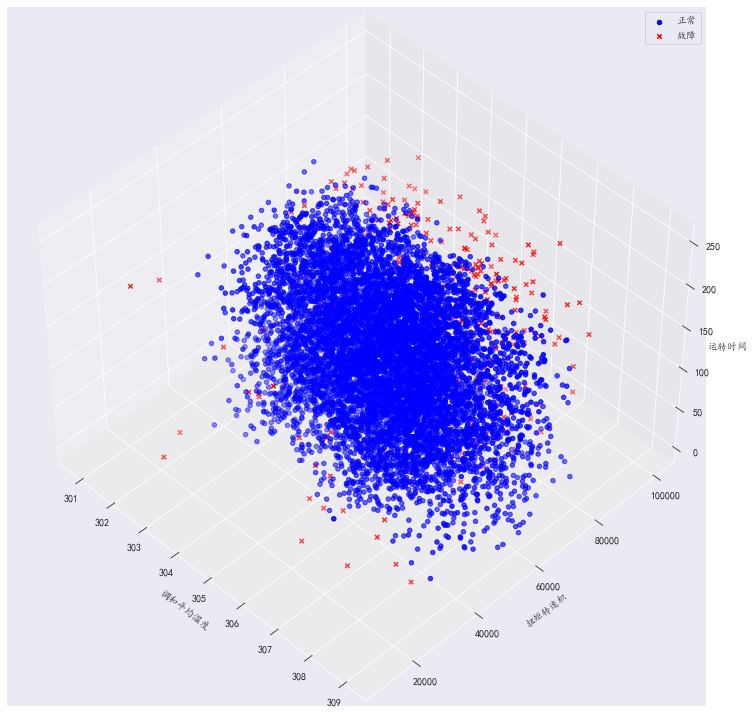

In [66]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 10))
ax = fig.gca(projection='3d')

ax.scatter(good['temp'], good['npm'], good['time'], c='b', marker='o', label='正常')
ax.scatter(bad['temp'], bad['npm'], bad['time'], c='r', marker='x', label='故障')
ax.view_init(elev=45, azim=-45)

ax.set_xlabel('调和平均温度')
ax.set_ylabel('扭矩转速积')
ax.set_zlabel('运转时间')
plt.legend()
plt.tight_layout()
plt.savefig(PIC_PATH + '3D Density.png', dpi=1200)

In [67]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

GOOD_LENGTH = int(len(good) * .8)
BAD_LENGTH = int(len(bad) * .8)
train = pd.concat([good.iloc[:GOOD_LENGTH], bad.iloc[:BAD_LENGTH]], axis=0)
plt.tight_layout()
test = pd.concat([good.iloc[GOOD_LENGTH:], bad.iloc[BAD_LENGTH:]], axis=0)

<Figure size 432x288 with 0 Axes>

In [68]:
from sklearn.metrics import confusion_matrix

In [69]:
def gaussian_kernel(x1, x2, sigma):
    return np.exp(-np.power(x1-x2, 2) / (2 * sigma**2))

In [70]:
npm = ss.fit_transform(new_data['npm'].to_numpy().reshape(-1, 1))
temp = ss.fit_transform(new_data['temp'].to_numpy().reshape(-1, 1))
time = ss.fit_transform(np.sqrt(2 * np.log1p(new_data['time'].to_numpy().reshape(-1, 1))) *
                        np.cos(2 * np.pi * new_data['time'].to_numpy().reshape(-1, 1)))
gauss_feature = gaussian_kernel(npm, temp, 3)
gauss_feature

array([[0.75900276],
       [0.140578  ],
       [0.9998813 ],
       ...,
       [0.99137635],
       [0.85661672],
       [0.95710782]])

<AxesSubplot:ylabel='Density'>

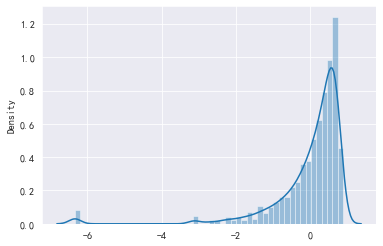

In [71]:
sns.distplot(time)

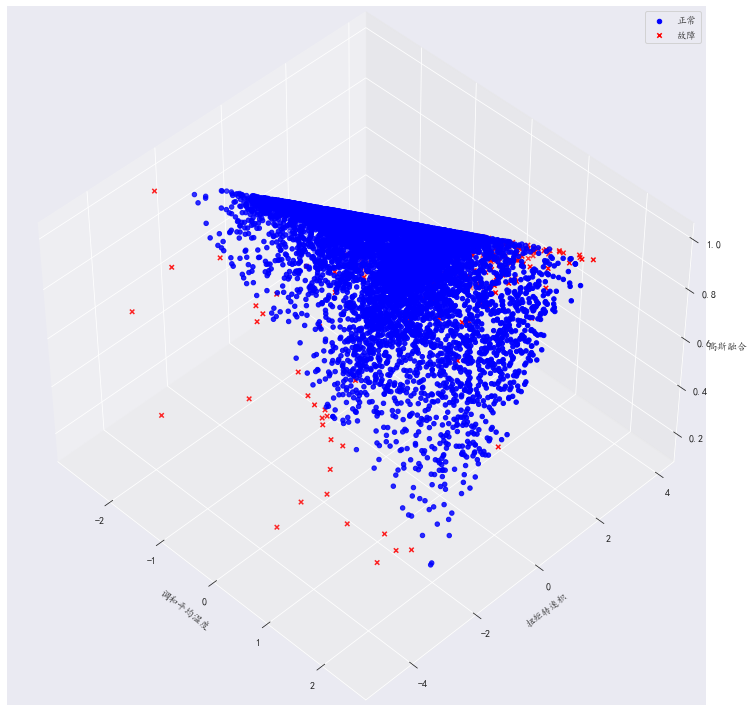

In [72]:
fig = plt.figure(figsize=(16, 10))
ax = fig.gca(projection='3d')
boolean = new_data['target'] == 0

ax.scatter(temp[boolean], npm[boolean], gauss_feature[boolean], c='b', marker='o', label='正常')
ax.scatter(temp[~boolean], npm[~boolean], gauss_feature[~boolean], c='r', marker='x', label='故障')
ax.view_init(elev=45, azim=-45)

ax.set_xlabel('调和平均温度')
ax.set_ylabel('扭矩转速积')
ax.set_zlabel('高斯融合')
plt.legend()
ax.view_init(elev=45, azim=-45)
plt.tight_layout()
plt.savefig(PIC_PATH + '3D Gaussian.png', dpi=1200)

<AxesSubplot:xlabel='time', ylabel='gaussian'>

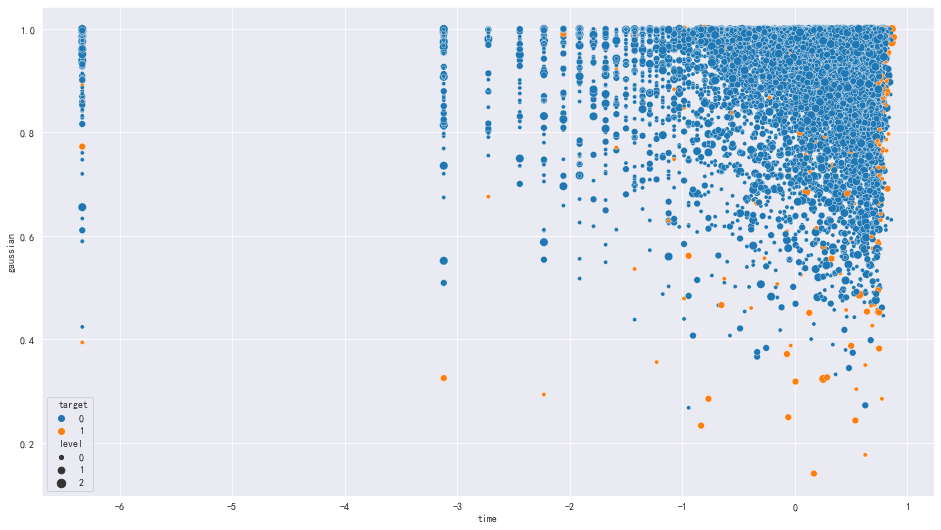

In [73]:
transform = new_data.copy()
transform['temp'] = temp
transform['npm'] = npm
transform['time'] = time
transform['gaussian'] = gauss_feature

plt.figure(figsize=(16, 9))
sns.scatterplot(data=transform, x='time', y='gaussian', size='level', hue='target')

In [74]:
from sklearn.mixture import BayesianGaussianMixture

numberic = ['temp', 'npm', 'gaussian']

bayes = BayesianGaussianMixture(tol=10, n_components=2, reg_covar=1e-1)
bayes.fit(transform.drop('target', axis=1))
y_hat = bayes.predict(transform.drop('target', axis=1))

In [75]:
f1_score(y_true=transform['target'], y_pred=y_hat, average='macro')

0.0931676889630415

In [76]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score

roc_auc_score(y_true=transform['target'],
              y_score=bayes.predict_proba(transform.drop('target', axis=1))[:, 1])

0.5735028346353823

In [77]:
recall_score(y_true=transform['target'], y_pred=y_hat)

0.946843853820598

In [78]:
confusion_matrix(transform['target'], y_hat)

array([[ 561, 8136],
       [  16,  285]], dtype=int64)

In [79]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from skopt import forest_minimize, space

def func_objective(param):
    param = dict(
        zip(['covariance_type', 'tol', 'reg_covar', 'max_iter'], param)
    )
    bayes_opt = BayesianGaussianMixture(n_components=2, **param)
    score = cross_val_score(bayes_opt,
                            X=transform.drop('target', axis=1),
                            y=transform['target'],
                            scoring=make_scorer(roc_auc_score),
                            cv=5)
    return 1 - score.mean()

In [80]:
space_opt = [
    space.Categorical(categories=['full', 'tied', 'diag', 'spherical'], name='covariance_type'),
    space.Real(1e-3, 15, name='tol'),
    space.Real(1e-3, 15, name='reg_covar'),
    space.Integer(50, 200, name='max_iter')
]

In [81]:
res = forest_minimize(func_objective, space_opt)
res.x

['tied', 9.147525310673194, 1.565312049339976, 53]

In [82]:
bayes_best = BayesianGaussianMixture(n_components=2,
                                     covariance_type='tied',
                                     tol=res.x[1],
                                     reg_covar=res.x[2],
                                     max_iter=res.x[3])
bayes_best.fit(transform.drop('target', axis=1))
y_hat = bayes_best.predict(transform.drop('target', axis=1))

In [83]:
f1_score(y_true=transform['target'], y_pred=y_hat, average='macro')

0.0323690719432197

In [84]:
roc_auc_score(y_true=transform['target'],
              y_score=bayes_best.predict_proba(transform.drop('target', axis=1))[:, 1])

0.5940414783881256

In [85]:
confusion_matrix(transform['target'], y_hat)

array([[   0, 8697],
       [   0,  301]], dtype=int64)

In [86]:
new_data['gauss'] = gauss_feature
new_data.index = range(len(new_data))
# new_data.drop('机器编号', axis=1, inplace=True)
new_data

temp      npm  level  time  target     gauss
0     301.799801  15864.8      0   213       1  0.759003
1     300.958445  94107.0      1    89       1  0.140578
2     300.858415  33142.0      0   149       1  0.999881
3     301.603348  51849.2      1   151       0  0.895236
4     301.603348  45946.6      2   154       0  0.962053
...          ...      ...    ...   ...     ...       ...
8993  303.524111  47318.0      1    14       0  0.997166
8994  303.575696  51897.6      2    17       0  0.998007
8995  303.724161  54943.0      1    22       0  0.991376
8996  303.772585  68288.0      2    25       0  0.856617
8997  303.772585  60300.0      1    30       0  0.957108

[8998 rows x 6 columns]

In [87]:
X = new_data.drop('target', axis=1)
y = new_data['target']
X

temp      npm  level  time     gauss
0     301.799801  15864.8      0   213  0.759003
1     300.958445  94107.0      1    89  0.140578
2     300.858415  33142.0      0   149  0.999881
3     301.603348  51849.2      1   151  0.895236
4     301.603348  45946.6      2   154  0.962053
...          ...      ...    ...   ...       ...
8993  303.524111  47318.0      1    14  0.997166
8994  303.575696  51897.6      2    17  0.998007
8995  303.724161  54943.0      1    22  0.991376
8996  303.772585  68288.0      2    25  0.856617
8997  303.772585  60300.0      1    30  0.957108

[8998 rows x 5 columns]

In [88]:
boolean = boolean.to_numpy()
true = X[boolean]
false = X[~boolean]

In [89]:
result_model = pd.DataFrame(index=['precision', 'recall', 'accuracy', 'F1_score'])

In [90]:
from sklearn.tree import DecisionTreeClassifier

out_data = false.sample(280, replace=False)
test_data = false.drop(out_data.index, axis=0)

score_list = []
model_list = []
for i in range(25):
    train_false = out_data.sample(250, replace=False)
    test_false = false.drop(train_false.index)
    sample = true.sample(2 * len(train_false), replace=False)
    X_train = pd.concat([train_false, sample], axis=0)
    y_train = y.iloc[X_train.index]
    dt = DecisionTreeClassifier(
        class_weight={0: 1, 1: 2},
        random_state=42
    )
    dt.fit(X_train, y_train)
    score_list.append(dt.score(X_train, y_train))
    model_list.append(dt)

model_list

[DecisionTreeClassifier(class_weight={0: 1, 1: 2}, random_state=42),
 DecisionTreeClassifier(class_weight={0: 1, 1: 2}, random_state=42),
 DecisionTreeClassifier(class_weight={0: 1, 1: 2}, random_state=42),
 DecisionTreeClassifier(class_weight={0: 1, 1: 2}, random_state=42),
 DecisionTreeClassifier(class_weight={0: 1, 1: 2}, random_state=42),
 DecisionTreeClassifier(class_weight={0: 1, 1: 2}, random_state=42),
 DecisionTreeClassifier(class_weight={0: 1, 1: 2}, random_state=42),
 DecisionTreeClassifier(class_weight={0: 1, 1: 2}, random_state=42),
 DecisionTreeClassifier(class_weight={0: 1, 1: 2}, random_state=42),
 DecisionTreeClassifier(class_weight={0: 1, 1: 2}, random_state=42),
 DecisionTreeClassifier(class_weight={0: 1, 1: 2}, random_state=42),
 DecisionTreeClassifier(class_weight={0: 1, 1: 2}, random_state=42),
 DecisionTreeClassifier(class_weight={0: 1, 1: 2}, random_state=42),
 DecisionTreeClassifier(class_weight={0: 1, 1: 2}, random_state=42),
 DecisionTreeClassifier(class_weig

In [91]:
from sklearn.base import ClassifierMixin
from sklearn.tree import BaseDecisionTree
from sklearn.metrics import accuracy_score

class Voting(ClassifierMixin, BaseDecisionTree):

    def __init__(self, ensemble: list):
        self.ensemble = ensemble

    def predict(self, x):
        result_df = pd.DataFrame()
        for c in range(len(self.ensemble)):
            m = self.ensemble[c]
            result_df[c] = m.predict(x)
        return result_df.mode(axis=1)

    def score(self, X, y, sample_weight=None):
        return accuracy_score(y, self.predict(X))

    def precision(self, x_test, y_test):
        return precision_score(y_test, self.predict(x_test))

    def recall(self, x_test, y_test):
        return recall_score(y_test, self.predict(x_test))

    def f1(self, x_test, y_test, method='macro'):
        return f1_score(y_test, self.predict(x_test), average=method)

In [92]:
voting = Voting(model_list)
voting.predict(test_data)

0
0   1
1   1
2   1
3   1
4   1
5   1
6   0
7   0
8   1
9   1
10  1
11  0
12  0
13  1
14  1
15  1
16  1
17  1
18  1
19  0
20  1

In [93]:
voting_score = []
voting_score.append(voting.precision(X, y))
voting_score.append(voting.recall(X, y))
voting_score.append(voting.score(X, y))
voting_score.append(voting.f1(X, y))
result_model['Voting_Pro'] = voting_score
voting_score

[0.265947888589398, 0.9833887043189369, 0.9086463658590798, 0.6845493068010386]

In [94]:
confusion_matrix(y, voting.predict(X))

array([[7880,  817],
       [   5,  296]], dtype=int64)

In [95]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=25)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.3)

rf.fit(X_train, y_train)
predict = rf.predict(X)
pre_test = rf.predict(X_test)
rf.score(X_test, y_test)

0.9796296296296296

In [96]:
def create_model(model_name, df, target):
    X_train, X_test, y_train, y_test = train_test_split(df, target, random_state=42, test_size=.3)
    model_name.fit(X_train, y_train)
    y_hat = model_name.predict(X)
    print(f1_score(y_test, model_name.predict(X_test)))
    return [
        precision_score(target, y_hat),
        recall_score(target, y_hat),
        model_name.score(X, target),
        f1_score(target, y_hat)
    ]

In [97]:
result_model

Voting_Pro
precision    0.265948
recall       0.983389
accuracy     0.908646
F1_score     0.684549

In [98]:
result_model['RF_pro'] = create_model(rf, X, y)
result_model['DT_pro'] = create_model(DecisionTreeClassifier(), X, y)

0.46017699115044247
0.47435897435897445


In [99]:
confusion_matrix(y, predict)

array([[8690,    7],
       [  51,  250]], dtype=int64)

In [100]:
X = X.drop('gauss', axis=1)

true = X[boolean]
false = X[~boolean]

train_false = false.sample(280, replace=False)
test_false = false.drop(train_false.index)

score_list2 = []
model_list2 = []
for i in range(15):
    sample = true.sample(3 * len(train_false), replace=False)
    X_train = pd.concat([train_false, sample], axis=0)
    y_train = y.iloc[X_train.index]
    dt = DecisionTreeClassifier(class_weight={0: 1, 1: 5})
    dt.fit(X_train, y_train)
    score_list2.append(dt.score(X_train, y_train))
    model_list2.append(dt)

In [101]:
voting2 = Voting(model_list2)


In [102]:
result_model['Voting'] = [
    voting2.precision(X, y),
    voting2.recall(X, y),
    voting2.score(X, y),
    voting2.f1(X, y)
]

In [129]:
result_model['RF'] = create_model(RandomForestClassifier(n_estimators=25), X, y)
result_model['DT'] = create_model(DecisionTreeClassifier(), X, y)

0.5210084033613445
0.4903225806451613


In [104]:
boolean2 = voting.predict(new_data.drop('target', axis=1))
boolean2 = (boolean2==1).to_numpy()
boolean2

array([[ True],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [105]:
second = new_data[boolean2]
second

temp      npm  level  time  target     gauss
0     301.799801  15864.8      0   213       1  0.759003
1     300.958445  94107.0      1    89       1  0.140578
2     300.858415  33142.0      0   149       1  0.999881
21    301.599735  71864.0      0   201       0  0.532117
22    301.551533  75454.2      0   203       0  0.457689
...          ...      ...    ...   ...     ...       ...
8897  303.859319  49800.4      0   180       0  0.997957
8904  303.759289  59195.1      1   203       0  0.966041
8905  303.759289  64238.4      1   206       0  0.912800
8972  303.324061  92820.2      0   172       1  0.350216
8984  303.620942  63746.1      1   207       0  0.907812

[1113 rows x 6 columns]

In [106]:
second['target'].value_counts()

0    817
1    296
Name: target, dtype: int64

<AxesSubplot:xlabel='temp', ylabel='npm'>

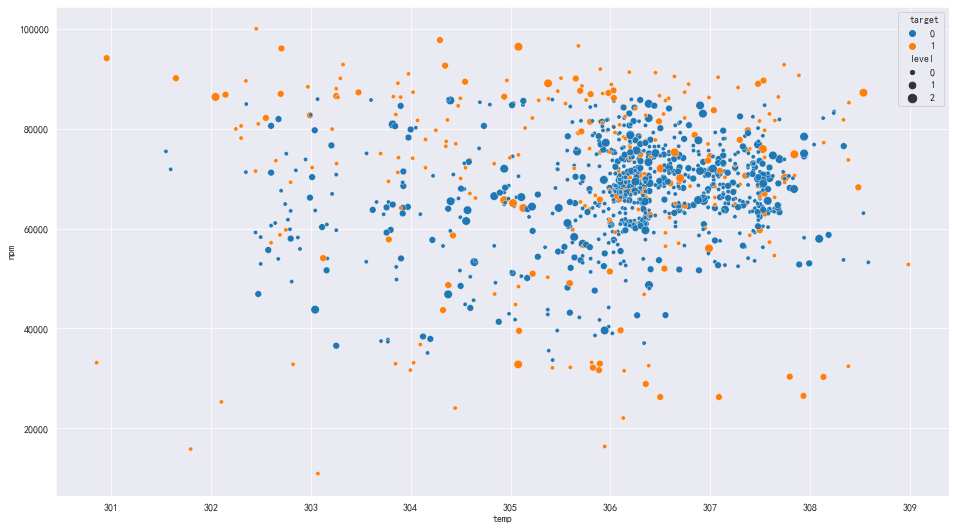

In [107]:
plt.figure(figsize=(16, 9))
sns.scatterplot(x='temp', y='npm', data=second, size='level', hue='target')

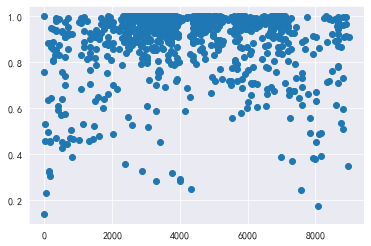

In [108]:
plt.plot(second['gauss'], 'o')

In [109]:
forecast = pd.read_excel('../data/forecast.xlsx', index_col=0)
forecast

统一规范代码 机器质量等级  室温（K）  室温（K）.1  转速（rpm）  扭矩（Nm）  使用时长（min）  是否发生故障  \
机器编号                                                                      
9125  M14860      M  298.1    308.6     1551    42.8          0       0   
9401  L47181      L  298.2    308.7     1408    46.3          3       0   
9566  L47182      L  298.1    308.5     1498    49.4          5       0   
9296  L47183      L  298.2    308.6     1433    39.5          7       0   
9376  L47184      L  298.2    308.7     1408    40.0          9       0   
...      ...    ...    ...      ...      ...     ...        ...     ...   
9244  H33243      H  302.3    310.9     1366    48.4        130       0   
9173  H33492      H  302.1    310.7     1294    62.4        101       0   
9057  L51260      L  302.0    310.4     1357    58.0        108       0   
9552  L51261      L  302.0    310.4     1336    58.2        110       0   
9086  L51267      L  301.9    310.4     1376    54.9        126       0   

        故障类别  
机器编号          
9125  Normal  
9401  Normal  
9566  Normal  
9296  Normal  
9376  Normal  
...      ...  
9244  Normal  
9173  Normal  
9057  Normal  
9552  Normal  
9086  Normal  

[1000 rows x 9 columns]

In [110]:
fore = pd.DataFrame()

fore['temp'] = harmonic_mean(forecast[['室温（K）', '室温（K）.1']])
fore['npm'] = (forecast['转速（rpm）'] * forecast['扭矩（Nm）']).tolist()
fore['level'] = forecast['机器质量等级'].map(level_map).tolist()
fore['time'] = forecast.iloc[:, -2].tolist()

fore

temp      npm  level  time
0    303.259140  66382.8      1     0
1    303.359170  65190.4      0     0
2    303.210847  74001.2      0     0
3    303.310877  56603.5      0     0
4    303.359170  56320.0      0     0
..          ...      ...    ...   ...
995  306.539693  66114.4      2     0
996  306.339654  80745.6      2     0
997  306.142391  78706.0      0     0
998  306.142391  77755.2      0     0
999  306.091001  75542.4      0     0

[1000 rows x 4 columns]

In [111]:
# result_model.drop('RF_pro_s', axis=1, inplace=True)
result_model

Voting_Pro    RF_pro    DT_pro    Voting        RF        DT
precision    0.265948  0.957692  0.859016  0.354293  0.988636  0.845161
recall       0.983389  0.827243  0.870432  0.973422  0.289037  0.870432
accuracy     0.908646  0.992998  0.990887  0.939764  0.976106  0.990331
F1_score     0.684549  0.887701  0.864686  0.743686  0.447301  0.857610

In [112]:
# result = voting.predict(fore)
# result

In [113]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
best_model = RandomForestClassifier(n_estimators=25).fit(X_train, y_train)
best_model.score(X_test, y_test)

0.9785185185185186

In [114]:
best_model.score(X, y)

0.9928873082907312

In [115]:
result = best_model.predict(fore)
forecast['是否发生故障'] = result
forecast.to_excel('../data/forecast.xlsx')

In [130]:
forecast['是否发生故障'].value_counts()

0    990
1     10
Name: 是否发生故障, dtype: int64

In [116]:
new_data['class'] = data['具体故障类别'].tolist()
to_csv = new_data[new_data['class']!='Normal']
to_csv

temp      npm  level  time  target     gauss class
0     301.799801  15864.8      0   213       1  0.759003   PWF
1     300.958445  94107.0      1    89       1  0.140578   PWF
2     300.858415  33142.0      0   149       1  0.999881   PWF
32    301.651566  90087.7      1    24       1  0.233241   PWF
101   302.303571  78114.0      0   202       1  0.497882   OSF
...          ...      ...    ...   ...     ...       ...   ...
8756  304.096910  36790.2      0   218       1  0.865694   TWF
8762  303.900493  86309.8      0    12       1  0.535888   PWF
8820  303.852278  82824.0      0   187       1  0.598395   OSF
8828  303.700428  75005.7      0   206       1  0.731844   OSF
8972  303.324061  92820.2      0   172       1  0.350216   OSF

[301 rows x 7 columns]

In [117]:
to_csv.to_csv('../data/bad_data.csv')
data

机器编号  统一规范代码 机器质量等级  室温（K）  机械工作温度  转速（rpm）  扭矩（Nm）  使用时长（min）  是否发生故障  \
0       84  L48027      L  296.4   307.4     2833     5.6        213       1   
1     6986  M15740      M  295.8   306.3     1235    76.2         89       1   
2     8047  L48083      L  295.7   306.2     2270    14.6        149       1   
3     4425  M15847      M  296.3   307.1     1534    33.8        151       0   
4     4519  H30402      H  296.3   307.1     1774    25.9        154       0   
...    ...     ...    ...    ...     ...      ...     ...        ...     ...   
8995  8680  M24855      M  298.8   308.4     1604    29.5         14       0   
8996   194  H39410      H  298.9   308.4     1632    31.8         17       0   
8997  7860  M24857      M  299.0   308.6     1645    33.4         22       0   
8998   138  H39412      H  299.0   308.7     1408    48.5         25       0   
8999   936  M24859      M  299.0   308.7     1500    40.2         30       0   

      具体故障类别  
0        PWF  
1        PWF  
2        PWF  
3     Normal  
4     Normal  
...      ...  
8995  Normal  
8996  Normal  
8997  Normal  
8998  Normal  
8999  Normal  

[8998 rows x 10 columns]

In [118]:
csv_data = pd.DataFrame()
csv_data['level'] = data['机器质量等级'].map(level_map)
csv_data['temp_1'] = data['室温（K）'].tolist()
csv_data['temp_2'] = data['机械工作温度'].tolist()
csv_data['efficient'] = list(data['转速（rpm）'] * data['扭矩（Nm）'])
csv_data['time'] = data['使用时长（min）'].tolist()
csv_data['target'] = data['是否发生故障'].tolist()
csv_data['class'] = data['具体故障类别'].tolist()

csv_data.to_csv('../data/all_data.csv')

In [119]:
csv_data

level  temp_1  temp_2  efficient  time  target   class
0         0   296.4   307.4    15864.8   213       1     PWF
1         1   295.8   306.3    94107.0    89       1     PWF
2         0   295.7   306.2    33142.0   149       1     PWF
3         1   296.3   307.1    51849.2   151       0  Normal
4         2   296.3   307.1    45946.6   154       0  Normal
...     ...     ...     ...        ...   ...     ...     ...
8995      1   298.8   308.4    47318.0    14       0  Normal
8996      2   298.9   308.4    51897.6    17       0  Normal
8997      1   299.0   308.6    54943.0    22       0  Normal
8998      2   299.0   308.7    68288.0    25       0  Normal
8999      1   299.0   308.7    60300.0    30       0  Normal

[8998 rows x 7 columns]

In [120]:
X.columns = ['调和平均温度', '扭矩转速积', '机器质量等级', '运行时间']
X

调和平均温度    扭矩转速积  机器质量等级  运行时间
0     301.799801  15864.8       0   213
1     300.958445  94107.0       1    89
2     300.858415  33142.0       0   149
3     301.603348  51849.2       1   151
4     301.603348  45946.6       2   154
...          ...      ...     ...   ...
8993  303.524111  47318.0       1    14
8994  303.575696  51897.6       2    17
8995  303.724161  54943.0       1    22
8996  303.772585  68288.0       2    25
8997  303.772585  60300.0       1    30

[8998 rows x 4 columns]

In [121]:
import eli5

eli5.show_weights(best_model, feature_names=X.columns.tolist())

In [122]:
def func_objective(param):
    param = dict(
        zip(
            ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_leaf_nodes'], param
        )
    )
    dt_opt = RandomForestClassifier(**param)
    score = cross_val_score(dt_opt,
                            X=X_train,
                            y=y_train,
                            scoring=make_scorer(f1_score),
                            cv=5)
    return 1 - score.mean()


space_opt = [
    space.Integer(15, 200, name='n_estimators'),
    space.Integer(2, 10, name='max_depth'),
    space.Integer(2, 15, name='min_samples_split'),
    space.Integer(2, 15, name='min_samples_leaf'),
    space.Integer(2, 15, name='max_leaf_nodes')
]

res = forest_minimize(func_objective, space_opt, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3394
Function value obtained: 0.6584
Current minimum: 0.6584
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.6467
Function value obtained: 0.6463
Current minimum: 0.6463
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.5862
Function value obtained: 0.5847
Current minimum: 0.5847
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.6303
Function value obtained: 0.6584
Current minimum: 0.5847
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3.2707
Function value obtained: 0.4514
Current minimum: 0.4514
Iteration No: 6 started. Evaluating

In [123]:
res

          fun: 0.41564674256799505
    func_vals: array([0.65844007, 0.64631885, 0.58470455, 0.65844007, 0.45144238,
       0.65844007, 0.65844007, 0.60271417, 0.63597403, 0.65844007,
       0.45421839, 0.46116794, 0.45192218, 0.65844007, 0.65844007,
       0.44894221, 0.45776649, 0.50222482, 0.43730392, 0.44739158,
       0.46297708, 0.53474722, 0.45413995, 0.43520186, 0.44447606,
       0.43133632, 0.42639425, 0.43087249, 0.46828454, 0.44721148,
       0.44403306, 0.46545699, 0.44453348, 0.43990663, 0.45936548,
       0.4912192 , 0.45137249, 0.44679607, 0.50425947, 0.51354626,
       0.46776296, 0.43332633, 0.43653406, 0.45869365, 0.4773018 ,
       0.47264256, 0.43133632, 0.43283327, 0.47306956, 0.46955121,
       0.4880389 , 0.47715918, 0.45365291, 0.45088546, 0.48301157,
       0.4647358 , 0.53290554, 0.46275748, 0.47995054, 0.49557078,
       0.46766   , 0.49039461, 0.46955538, 0.48164965, 0.62774892,
       0.45370288, 0.4381241 , 0.43233764, 0.43349941, 0.43604359,
       0.415

In [124]:
param = dict(
        zip(
            ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_leaf_nodes'], res.x
        )
    )

create_model(
    RandomForestClassifier(**param),
    X,
    y
)

0.4123711340206186


[0.9831932773109243,
 0.38870431893687707,
 0.9793287397199377,
 0.5571428571428572]

In [125]:
res.x

[49, 9, 6, 2, 15]

In [126]:
RES = pd.DataFrame(res.x_iters)
RES.columns = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_leaf_nodes']
RES.to_excel('../data/iter.xlsx')
RES

n_estimators  max_depth  min_samples_split  min_samples_leaf  \
0             90         10                  3                 8   
1             45          3                  5                12   
2             33          5                  5                14   
3             52          2                  6                 4   
4            193          5                  6                 5   
..           ...        ...                ...               ...   
95           179          6                  3                 8   
96            89          7                 13                 7   
97           133          5                 10                 3   
98           139          9                  2                11   
99           194          7                  4                15   

    max_leaf_nodes  
0                4  
1                4  
2               11  
3                9  
4               13  
..             ...  
95              15  
96               8  
97               6  
98              10  
99              15  

[100 rows x 5 columns]

In [127]:
from pickle import dump

with open('../models/solve1_model.pkl', 'wb') as f:
    dump(best_model, f)

X.to_csv('../data/solve1_X.csv')
y.to_csv('../data/solve_y.csv')

In [128]:
from sklearn.linear_model import LogisticRegression

create_model(LogisticRegression(), X, y)

0.05128205128205127


[1.0, 0.026578073089700997, 0.9674372082685041, 0.05177993527508091]